# Validation DPsim gegen MATPAT

### Load Modules

In [7]:
import sys

sys.path.insert(0,'/home/mmo-gog/dpsim/build/')
sys.path.insert(0,'/home/mmo-gog/dpsim/python/src/dpsim')

import iaewreader
import dpsimpy

from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.io
import matplotlib.pyplot as plt


# %matplotlib widget

### Load MATPAT Results

In [8]:
path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Originial_Static_Dynamic_Data_9Bus_System_incl_simulations.mat'
iaew_results = scipy.io.loadmat(path_file, simplify_cells= True)
iaew_time=iaew_results['res_dyn_only_SYN']['Time']

### Run Power Flow Simulation in DPsim

In [9]:
sim_name_pf = '9Bus_SYN_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Originial_Static_Dynamic_Data_9Bus_System_incl_simulations.mat'
mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.load_mpc(domain=iaewreader.Domain.PF)
system_pf = mpc_reader.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

dpsim_result_file = 'logs/' + sim_name_pf + '/' + sim_name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

dpsim_results = pd.DataFrame(columns=['Bus', 'V_mag(pu)', 'V_angle(deg)', 'P(MW)', 'Q(MVAr)'])
base_power = 1 #mw
for i in range(len(system_pf.nodes)):
    node_name = system_pf.nodes[i].name() #ex. N5
    node_number = node_name.replace('N', '')
    node_baseV = mpc_reader.mpc_bus_data.loc[mpc_reader.mpc_bus_data['bus_i'] == int(node_number), 'baseKV'].iloc[0] * 1e3
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / node_baseV, 3)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1])*180/np.pi, 3)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 3)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 3)])

dpsim_results

column number: 24
results length: 2
real column names: []
complex column names: ['N1.S', 'N1.V', 'N10.S', 'N10.V', 'N11.S', 'N11.V', 'N12.S', 'N12.V', 'N2.S', 'N2.V', 'N3.S', 'N3.V', 'N4.S', 'N4.V', 'N5.S', 'N5.V', 'N6.S', 'N6.V', 'N7.S', 'N7.V', 'N8.S', 'N8.V', 'N9.S', 'N9.V']


[13:20:03.147086 9Bus_SYN_PF info] Initialize simulation: 9Bus_SYN_PF
[13:20:03.147510 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N4
[13:20:03.147517 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N5
[13:20:03.147521 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N6
[13:20:03.147524 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N7
[13:20:03.147527 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N8
[13:20:03.147530 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N9
[13:20:03.147532 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N10
[13:20:03.147535 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N11
[13:20:03.147538 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N12
[13:20:03.147766 9Bus_SYN_PF info] Scheduling tasks.
[13:20:03.147928 9Bus_SYN_PF info] Scheduling done.
[13:20:03.147930 9Bus_SYN_PF info] Opening interfaces.
[13:20:03.147931 9Bus_SYN_PF info] Sta

,Bus,V_mag(pu),V_angle(deg),P(MW),Q(MVAr)
0,N1,1.000,0.000,476.271,220.123
1,N2,0.950,-7.544,120.000,7.138
2,N3,1.000,-8.008,120.000,87.990
3,N4,1.026,-3.514,-0.000,0.000
4,N5,0.976,-9.505,-0.000,0.000
5,N6,0.975,-10.077,-0.000,0.000
6,N7,0.911,-15.168,-0.000,0.000
7,N8,0.949,-9.782,-0.000,0.000
8,N9,0.959,-9.346,-0.000,0.000
9,N10,0.959,-13.101,-200.000,-50.000


### Declare function to run dynamic simulations in DPsim

In [10]:
def run_simulation(domain="SP", with_avr=True, with_tg=True, with_pss=True, with_fault=True):
    
    dpsim_domain = None
    if domain=="SP":
        dpsim_domain = dpsimpy.Domain.SP
    elif domain=="DP":
        dpsim_domain = dpsimpy.Domain.DP
    else:
        domain=="EMT"
        dpsim_domain = dpsimpy.Domain.EMT
        
    sim_name_dyn = domain + '_only_SYN_case9_dyn'
    dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn)

    mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                                   mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
    if (domain=="SP"):
        mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.SP, frequency=50, with_avr=with_avr, with_tg=with_tg, with_pss=with_pss)
    elif (domain=="DP"):
        mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.DP, frequency=50, with_avr=with_avr, with_tg=with_tg, with_pss=with_pss)
    elif (domain=="EMT"):
        mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.EMT, frequency=50, with_avr=with_avr, with_tg=with_tg, with_pss=with_pss)
    
    ### Extend topology with switch between node N15 and groud
    sw=None
    switch_closed = 1e-9
    switch_open = 1e18
    if with_fault:
        if domain=="SP":
            sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
            sw.set_parameters(switch_open, switch_closed)
            sw.open()
            mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])
        elif domain=="DP":
            sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
            sw.set_parameters(switch_open, switch_closed)
            sw.open()
            mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.dp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])
        else:
            sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.info)
            sw.set_parameters(switch_open, switch_closed)
            sw.open()
            mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.emt.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])
    
    # create dpsim topology
    mpc_reader.create_dpsim_topology()

    # initialize node voltages using pf results
    system_dyn = mpc_reader.system
    if domain=="EMT":
        system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)
    else:
        system_dyn.init_with_powerflow(systemPF=system_pf)

    logger = dpsimpy.Logger(sim_name_dyn)
    for node in system_dyn.nodes:
        logger.log_attribute(node.name()+'.V', 'v', node)

    # Log electrical power and omega of SGs
    for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
        logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.Pm'.format(gen_name), 'Tm', mpc_reader.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.Ef'.format(gen_name), 'Ef', mpc_reader.dpsimpy_comp_dict[gen_name][0])

    # Parametrize and run simulation
    sim = dpsimpy.Simulation(sim_name_dyn, dpsimpy.LogLevel.info)
    sim.set_system(system_dyn)
    sim.set_time_step(1e-4)
    sim.set_final_time(2)
    sim.set_domain(dpsim_domain)
    sim.set_solver(dpsimpy.Solver.MNA)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
    sim.do_init_from_nodes_and_terminals(True)
    sim.do_system_matrix_recomputation(True)
    sim.add_logger(logger)

    # add event
    if with_fault:
        sw_event_1 = dpsimpy.event.SwitchEvent(0.1, sw, True)
        sw_event_2 = dpsimpy.event.SwitchEvent(0.25, sw, False)
        sim.add_event(sw_event_1)
        sim.add_event(sw_event_2)

    sim.run()

    dpsim_result_file = 'logs/' + sim_name_dyn + '/' + sim_name_dyn + '.csv'

    return dpsim_result_file

### Run SP Simulation

In [11]:
dpsim_result_file = run_simulation(domain="SP", with_avr=True, with_tg=True, with_pss=True, with_fault=True)
ts_dpsim_sp = read_timeseries_csv(dpsim_result_file)
phasors = ts.phasors(ts_dpsim_sp)

[13:20:03.630161 SP_only_SYN_case9_dyn info] Initialize simulation: SP_only_SYN_case9_dyn
[13:20:03.630241 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[13:20:03.631987 SP_only_SYN_case9_dyn_Solver warning] Linear solver configuration is not used!
[13:20:03.634527 SP_only_SYN_case9_dyn info] Scheduling tasks.
[13:20:03.634730 SP_only_SYN_case9_dyn info] Scheduling done.
[13:20:03.634733 SP_only_SYN_case9_dyn info] Opening interfaces.
[13:20:03.634734 SP_only_SYN_case9_dyn info] Start synchronization with remotes on interfaces
[13:20:03.634735 SP_only_SYN_case9_dyn info] Synchronized simulation start with remotes
[13:20:03.634736 SP_only_SYN_case9_dyn info] Start simulation: SP_only_SYN_case9_dyn
[13:20:03.634738 SP_only_SYN_case9_dyn info] Time step: 1.000000e-04
[13:20:03.634740 SP_only_SYN_case9_dyn info] Final time: 2.000000e+00
[13:20:04.399070 SP_only_SYN_case9_dyn info] Simulation calculation time: 0.764287
[13:20:04.418821 SP_only_SYN_case9_dyn info] Sim

1.000000e-01: Handle event time
2.500000e-01: Handle event time
column number: 25
results length: 20001
real column names: ['Gen_N1.Ef', 'Gen_N1.Pe', 'Gen_N1.Pm', 'Gen_N1.w', 'Gen_N2.Ef', 'Gen_N2.Pe', 'Gen_N2.Pm', 'Gen_N2.w', 'Gen_N3.Ef', 'Gen_N3.Pe', 'Gen_N3.Pm', 'Gen_N3.w']
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N12.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']


Compare all Node Voltage and Generator Variables DPsim vs IAEW

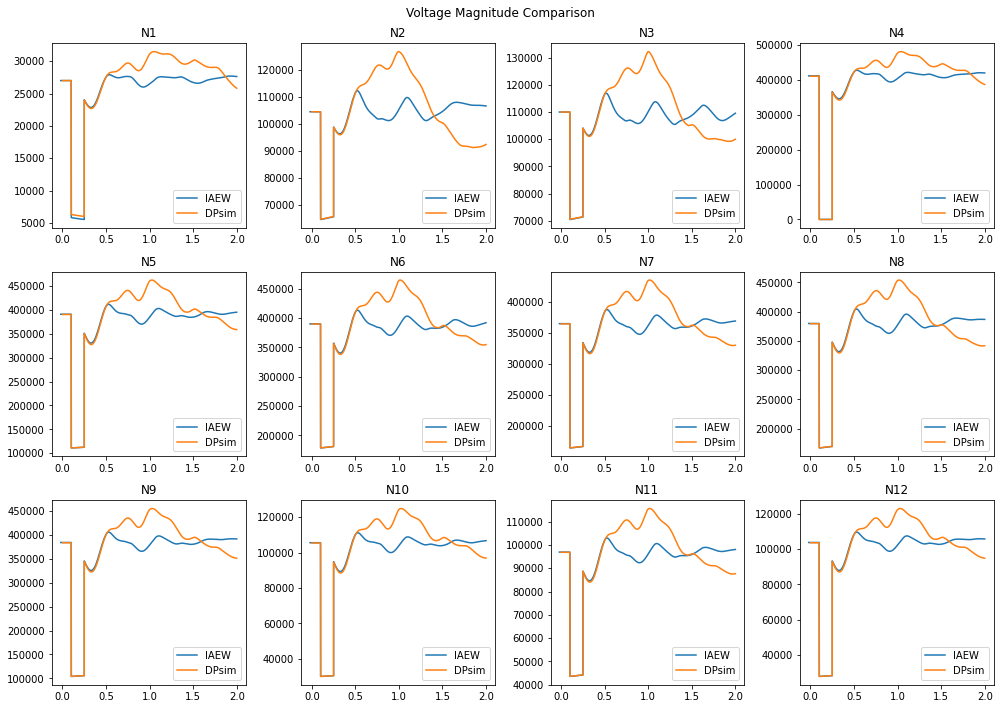

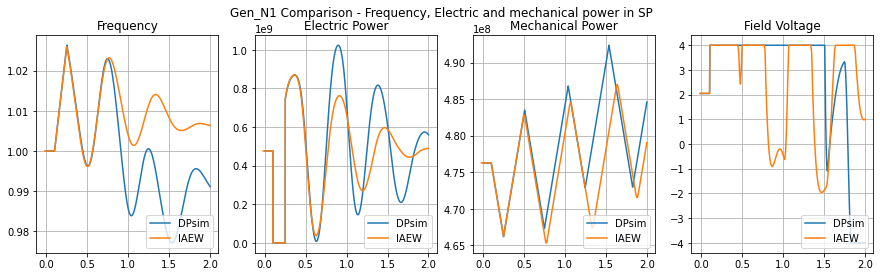

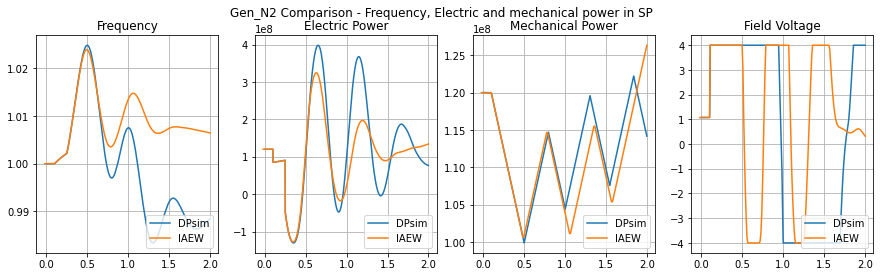

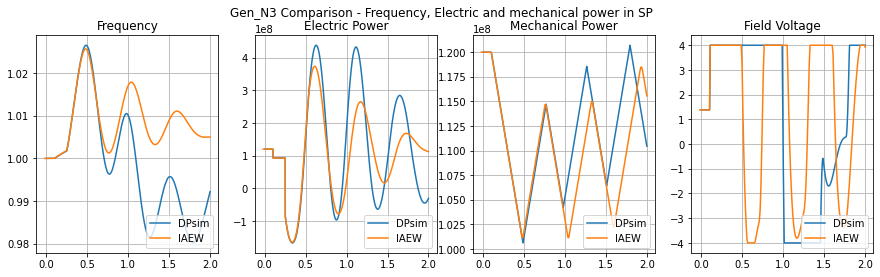

In [12]:
# iterator for angles, magnitude and bus
a = 0
m = 1
bus = 0
# Number of rows and columns for subplots
num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
fig.suptitle('Voltage Magnitude Comparison')

for row in range(num_rows):
    for col in range(num_cols):
        node_name = f"N{row * num_cols + col + 1}"
        
        V_base = iaew_results['case9_static_only_SYN']['bus'][bus, 9] * 1e3
        angle = iaew_results['res_dyn_only_SYN']['Variables'][:, a]
        magnitude = iaew_results['res_dyn_only_SYN']['Variables'][:, m] * V_base

        # Plot on the corresponding subplot
        axes[row, col].plot(iaew_time, magnitude, label='IAEW')
        axes[row, col].plot(ts_dpsim_sp[node_name + '.V'].time, ts_dpsim_sp[node_name + '.V'].abs().values, label='DPsim')
        axes[row, col].set_title(node_name)
        axes[row, col].legend(loc='lower right')

        a = a + 2
        m = m + 2
        bus = bus + 1
        
        #axes[row, col].set_xlim([-0.01, 0.2])
        #axes[row, col].set_ylim([26500, 27500])

plt.tight_layout()
plt.show()

#Plot the Generator frequency, mechanical and electrical power
#iaew_raws_delomega = [78, 80, 82]
iaew_raws_delomega = [1, 5, 9]
#iaew_raws_delomega = [48, 49, 50]
iaew_raws_Pe = [121, 122, 123]
iaew_raws_Pm = [26, 34, 42]
iaew_raws_efd = [27, 35, 43]
gen_baseS_dpsim=[6.708204e+08, 5.000000e+08, 5.000000e+08]

for gen_name, delomega_idx, Pe_idx, Pm_idx, baseS_idx, Ef_idx in zip(["Gen_N1", "Gen_N2", "Gen_N3"], iaew_raws_delomega, iaew_raws_Pe, iaew_raws_Pm, gen_baseS_dpsim, iaew_raws_efd):
    # Plotting DPSim and IAEW results on the same subplot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(gen_name + ' Comparison - Frequency, Electric and mechanical power in SP')

    # Plot DPSim results
    frequency_dpsim = ts_dpsim_sp[gen_name + '.w'].values
    Epower_dpsim = ts_dpsim_sp[gen_name + '.Pe'].values*baseS_idx
    Mpower_dpsim = ts_dpsim_sp[gen_name + '.Pm'].values*baseS_idx
    #Mpower_dpsim = ts_dpsim_sp[gen_name + '.Pm'].values
    Ef_dpsim = ts_dpsim_sp[gen_name + '.Ef'].values
    t_dpsim = ts_dpsim_sp[gen_name + '.Pe'].time
    ax1.plot(t_dpsim, frequency_dpsim, label='DPsim')
    ax2.plot(t_dpsim, Epower_dpsim, label='DPsim')
    ax3.plot(t_dpsim, Mpower_dpsim, label='DPsim')
    ax4.plot(t_dpsim, Ef_dpsim, label='DPsim')

    # Plot IAEW results
    #frequency_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, delomega_idx]
    frequency_iaew = iaew_results['res_dyn_only_SYN']['States'][:, delomega_idx]
    Epower_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, Pe_idx]*1000e6
    Mpower_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, Pm_idx]*1000e6
    #Mpower_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, Pm_idx]
    Ef_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, Ef_idx]
    ax1.plot(iaew_time, frequency_iaew, label='IAEW')
    ax2.plot(iaew_time, Epower_iaew, label='IAEW')
    ax3.plot(iaew_time, Mpower_iaew, label='IAEW')
    ax4.plot(iaew_time, Ef_iaew, label='IAEW')

    # Set titles for subplots
    ax1.set_title('Frequency')
    ax2.set_title('Electric Power')
    ax3.set_title('Mechanical Power')
    ax4.set_title('Field Voltage')

    # Add legend to the subplots
    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    ax3.legend(loc='lower right')
    ax4.legend(loc='lower right')
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()

plt.show()